In [5]:
import importlib
import sys
from urllib.request import urlretrieve

# Imports.
import numpy as np
import meshcat
from ipywidgets import interact, FloatSlider, ToggleButton
from IPython.display import display

import pydrake.all
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, PlanarSceneGraphVisualizer, SceneGraph, Simulator)
from pydrake.systems.jupyter_widgets import WidgetSystem
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant

import underactuated
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
import underactuated.meshcat_utils as mutil
from pydrake.examples.pendulum import PendulumGeometry, PendulumPlant, PendulumInput
from pydrake.all import Linearize, LinearQuadraticRegulator,VectorSystem
import math
from pydrake.all import Jacobian, MathematicalProgram, Solve, Variables, Polynomial
import numpy as np

In [6]:
### LQR

# Prepare
builder = DiagramBuilder()
pendulum = builder.AddSystem(PendulumPlant())
context = pendulum.CreateDefaultContext()
pendulum.get_input_port(0).FixValue(context, [0])
context.SetContinuousState([np.pi, 0])

# linearize the system at [pi, 0]
linearized_pendulum = Linearize(pendulum, context)

# LQR
Q = np.diag((10., 1.))
R = [1.]
(K, S) = LinearQuadraticRegulator(linearized_pendulum.A(), linearized_pendulum.B(), Q, R)

In [7]:
### Prepare non-linear system

# constants
pi = np.pi
g = 9.81
m = 1.
l = 0.5
d = 0.1

# non-linear dyamics
prog = MathematicalProgram()
x = prog.NewIndeterminates(2, "x")
x1 = x[0]
x2 = x[1]
Tsin = -(x1-pi) + (x1-pi)**3/6  # 3rd order taylor expansion of sin(x) around pi
r = [pi, 0]  # reference
u = -K.dot(x)[0] # control input
u2 = -K.dot(x-r)[0] # control input with reference
fn = [x2, (u2-d*x2-Tsin*m*g*l)/(m*l*l)]
print(u2)

( - 2.4259662559187145 * x(1) - 10.741011052080012 * (-3.1415926535897931 + x(0)))


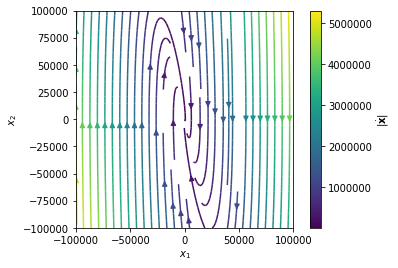

In [8]:
from underactuated import plot_2d_phase_portrait

# plot the phase portrait
f = lambda x: [x[1], ((- 2.4259662559187145 * x[1] - 10.741011052080012 * (-3.1415926535897931 + x[0]))-d*x[1]-np.sin(x[0])*m*g*l)/(m*l*l)]
xlim = (-100000, 100000)
plot_2d_phase_portrait(f, x1lim=xlim, x2lim=xlim)

In [9]:
### Lyapunov analysis, fix V and find Lagrange multiplier.

# cost-to-go of LQR as Lyapunov candidate
V = (x-r).dot(S.dot(x-r)) 
Vdot = Jacobian([V], x).dot(fn)[0]

# Define the Lagrange multiplier.
lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0].ToExpression()

# Optimization setup
rho = 22.
prog.AddSosConstraint(-Vdot + lambda_*(V-rho))
prog.AddSosConstraint(V)
prog.AddSosConstraint(lambda_)

result = Solve(prog)

# Print result
if (result.is_success()):
    print(f"Verified that {str(V)} < {rho} is in the region of attraction.")
    #print(Polynomial(result.GetSolution(lambda_)))
else:
    print("failed")

Verified that ((x(1) * (0.60649156397967863 * x(1) + 2.6852527630200029 * (-3.1415926535897931 + x(0)))) + ((-3.1415926535897931 + x(0)) * (2.6852527630200025 * x(1) + 15.232066986722771 * (-3.1415926535897931 + x(0))))) < 22.0 is in the region of attraction.


In [10]:
x0 = np.pi*2/3
x1 = 1
FV = ((x1* (0.60649156397967863 * x1+ 2.6852527630200029 * (-3.1415926535897931 + x0))) + ((-3.1415926535897931 + x0) * (2.6852527630200025 * x1+ 15.232066986722771 * (-3.1415926535897931 + x0)))) < 22.0
print(f"under IV x=[{x0}, {x1}], it is {FV} in RoA")

under IV x=[2.0943951023931953, 1], it is True in RoA
